In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils, cluster_utils, random_forest_utils

### Get stock data

In [2]:
query_date = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    --where ticker in ('T', 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    stocks as (
        select 
            market_datetime
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            , avg(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_average
            , max(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_high
            , min(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_low
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{query_date}'
        ),
    summary as (
        select *
            , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days 
                as hundred_fifty_average_open_diff
            , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days 
                as fifty_ten_average_open_diff
            , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days 
                as hundred_high_low_open_diff
            , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days 
                as hundred_fifty_average_volume_diff
            , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days 
                as fifty_ten_average_volume_diff
            --, (forward_average - average_price_today) / average_price_today as target
            , (forward_high - forward_low) / forward_average as target
        from stocks
        where forward_average is not null
        and market_datetime > '{query_date}'::date + interval '100' day)
    select *
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, sector) as sector_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, sector) as sector_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, industry) as industry_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, industry) as industry_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime) as market_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime) as market_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime) as market_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime) as market_fifty_ten_average_volume_diff
    from summary
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,...,sector_hundred_high_low_open_diff,sector_fifty_ten_average_volume_diff,industry_hundred_fifty_average_open_diff,industry_fifty_ten_average_open_diff,industry_hundred_high_low_open_diff,industry_fifty_ten_average_volume_diff,market_hundred_fifty_average_open_diff,market_fifty_ten_average_open_diff,market_hundred_high_low_open_diff,market_fifty_ten_average_volume_diff
0,2010-04-12 05:00:00,IPG,Technology,Advertising,8.7700,4747955.0,7.598529,7.733529,8.507273,8.77,...,0.239235,0.195816,-0.017767,-0.100050,0.274800,0.343074,-0.004418,-0.046146,0.185709,0.106942
1,2010-04-12 05:00:00,ALK,Transportation,Air Freight/Delivery Services,10.7275,2223092.0,9.241140,9.305441,10.309318,10.60,...,0.260142,0.304701,-0.006958,-0.107881,0.260142,0.304701,-0.004418,-0.046146,0.185709,0.106942
2,2010-04-12 05:00:00,MOD,Capital Goods,Auto Parts:O.E.M.,12.7750,318927.0,10.661176,10.431373,11.900909,12.90,...,0.266336,0.003669,-0.013209,-0.094057,0.341417,-0.097405,-0.004418,-0.046146,0.185709,0.106942
3,2010-04-12 05:00:00,LDL,Capital Goods,Auto Parts:O.E.M.,8.1900,67441.0,7.319265,7.670392,8.032727,8.49,...,0.266336,0.003669,-0.013209,-0.094057,0.341417,-0.097405,-0.004418,-0.046146,0.185709,0.106942
4,2010-04-12 05:00:00,NYCB,Finance,Banks,17.5550,3876729.0,15.647941,15.968039,16.824545,17.45,...,0.163794,0.179781,-0.020456,-0.053639,0.177650,0.176304,-0.004418,-0.046146,0.185709,0.106942


### Explore data

In [3]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

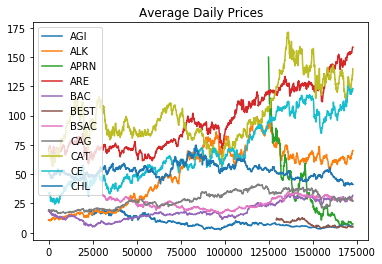

In [4]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='average_price_today', 
                           title='Average Daily Prices')

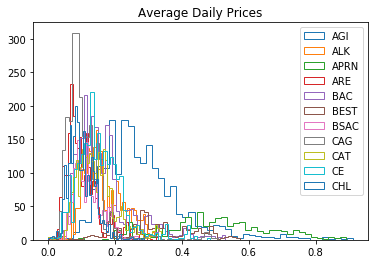

In [5]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='target', 
                           title='Average Daily Prices',
                           plot_type='histogram',
                           bins=50)

### Build random forest

#### Target: Open Price 10 Days from Now

In [6]:
temp = df.copy()

# y = temp.groupby('symbol')['percent_diff'].shift(-1)
y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'market_datetime_month', 'market_datetime_day_of_week', 
                  'forward_average', 'forward_high', 'forward_low', 'target']

In [12]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(train_x.drop(cols_to_ignore, axis=1), train_y)


prediction = regression.predict(train_x.drop(cols_to_ignore, axis=1))



In [25]:
prediction_df = pd.DataFrame(prediction, index=train_x.index, columns=['prediction'])
train = pd.merge(train_x, prediction_df, left_index=True, right_index=True)

train['error'] = train_y - train['prediction']

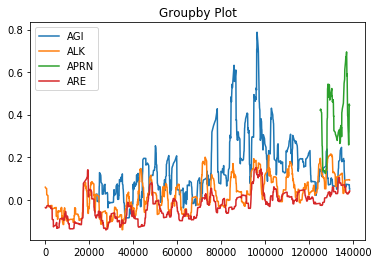

In [29]:
cluster_utils.groupby_plot(df=train,
                           groupby='symbol',
                           column='error',
                           n_lines=3
                         )

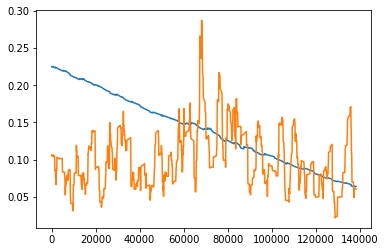

In [35]:
temp = train[train['symbol'] == 'CHL']
plt.plot(temp.prediction)
plt.plot(temp.target)
plt.show()